In [1]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import CSVLogger
import torch
import scipy as sp
import json
import numpy as np
from glob import glob
import anndata
import pandas as pd
from src.single_vae import VAE
from src.multi_vae import CrossSpeciesVAE
from src.callbacks import StageAwareEarlyStopping
from src.data import CrossSpeciesDataModule
import pickle
from sklearn.metrics import adjusted_mutual_info_score, adjusted_rand_score
import scanpy as sc
import matplotlib.pyplot as plt
import umap
import hnswlib

def _tanh_scale(x,scale=10,center=0.5):
    return center + (1-center) * np.tanh(scale * (x - center))

def _united_proj(wpca1, wpca2, k=20, metric="cosine", ef=200, M=48):

    metric = 'l2' if metric == 'euclidean' else metric
    metric = 'cosine' if metric == 'correlation' else metric
    labels2 = np.arange(wpca2.shape[0])
    p2 = hnswlib.Index(space=metric, dim=wpca2.shape[1])
    p2.init_index(max_elements=wpca2.shape[0], ef_construction=ef, M=M)
    p2.add_items(wpca2, labels2)
    p2.set_ef(ef)
    idx1, dist1 = p2.knn_query(wpca1, k=k)

    if metric == 'cosine':
        dist1 = 1 - dist1
        dist1[dist1 < 1e-3] = 1e-3
        dist1 = dist1/dist1.max(1)[:,None]
        dist1 = _tanh_scale(dist1,scale=10, center=0.7)
    else:
        sigma1 = dist1[:,4]
        sigma1[sigma1<1e-3]=1e-3
        dist1 = np.exp(-dist1/sigma1[:,None])
        
    Sim1 = dist1  # np.exp(-1*(1-dist1)**2)
    knn1v2 = sp.sparse.lil_matrix((wpca1.shape[0], wpca2.shape[0]))
    x1 = np.tile(np.arange(idx1.shape[0])[:, None], (1, idx1.shape[1])).flatten()
    knn1v2[x1.astype('int32'), idx1.flatten().astype('int32')] = Sim1.flatten()
    return knn1v2.tocsr()

from pynndescent import NNDescent

def find_nearest_neighbors(L1, L2, n_neighbors=15, metric='correlation'):
    """
    Finds the nearest neighbors from L1 (query) to L2 (index) using pynndescent.

    Parameters:
        L1 (np.ndarray): Query embeddings of shape (num_queries, embedding_dim).
        L2 (np.ndarray): Index embeddings of shape (num_index, embedding_dim).
        n_neighbors (int): Number of neighbors to find. Default is 5.
        metric (str): Distance metric to use. Default is 'euclidean'.

    Returns:
        indices (np.ndarray): Indices of nearest neighbors in L2 for each query in L1.
        distances (np.ndarray): Distances to nearest neighbors for each query in L1.
    """
    # Validate inputs
    if not isinstance(L1, np.ndarray) or not isinstance(L2, np.ndarray):
        raise ValueError("L1 and L2 must be numpy arrays.")
    
    if L1.shape[1] != L2.shape[1]:
        raise ValueError("L1 and L2 must have the same embedding dimension.")

    # Build the index on L2
    index = NNDescent(L2, metric=metric, n_neighbors=n_neighbors)
    
    # Query the nearest neighbors for L1
    indices, distances = index.query(L1, k=n_neighbors)
    
    return indices, distances

/opt/jupyter-envs/generate-cross-species/atar-jupyter/conda/lib/python3.11/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
adata1 = anndata.read_h5ad('data/fish/full.h5ad')
adata2 = anndata.read_h5ad('data/frog/full.h5ad')

adata1.X = adata1.X.astype('float32')
adata2.X = adata2.X.astype('float32')

emb1 = adata1.varm['esm']
emb2 = adata2.varm['esm']

emb1 = torch.from_numpy(emb1).float()
emb2 = torch.from_numpy(emb2).float()

XY_raw = _united_proj(emb1.numpy(), emb2.numpy(), k=25, metric='euclidean') # 25 IS THE BEST I'VE TRIED (I tried 10, 50, 100) - HOW CAN I DETERMINE THIS MORE PROGRAMMATICALLY?
YX_raw = _united_proj(emb2.numpy(), emb1.numpy(), k=25, metric='euclidean')

XY = XY_raw.copy()
YX = YX_raw.copy()
XY.data[:]=1
YX.data[:]=1

G = XY + YX.T

G.data[G.data>1]=0
G.eliminate_zeros()
x, y = G.nonzero()


G = XY_raw/2 + YX_raw.T/2
G[x,y] = 0
G.eliminate_zeros()
x, y = G.nonzero()

homology_edges = {}
homology_edges[0] = {}
homology_edges[0][1] = torch.tensor(np.vstack((x,y)).T)

homology_edges[1] = {}
homology_edges[1][0] = torch.tensor(np.vstack((y,x)).T)

homology_scores = {}
homology_scores[0] = {}
homology_scores[0][1] = torch.tensor(G.data).float()

homology_scores[1] = {}
homology_scores[1][0] = torch.tensor(G.data).float()

# pickle.dump((homology_edges,homology_scores), open('homology_zfxe.p','wb'))

In [3]:
# adata1 = adata1[adata1.obs['TimeID'] != '4hpf'].copy()
# adata2 = adata2[adata2.obs['Developmental_stage'] != 'Stage_8'].copy()

species_data = {
    "fish": adata1,
    "frog": adata2,
}

emb_data = {
    "fish": emb1,
    "frog": emb2, 
}
data_module = CrossSpeciesDataModule(
    species_data = species_data,
    batch_size=512,
    num_workers=0,
    val_split=0.001,
    test_split=0.001,
    yield_pairwise=False,
    subsample_size=10000,
    subsample_by={
        "fish": "cell_type",
        "frog": "cell_type",   
    }
)
data_module.setup()

species_data_sub = {k: data_module.train_dataset.epoch_data[k][data_module.train_dataset.epoch_indices[k]].copy() for k in data_module.train_dataset.epoch_data}



In [6]:
# species_data_sub = pickle.load(open('data.p','rb'))

adata1 = species_data_sub['fish']
adata2 = species_data_sub['frog']

batch_size = 256

data_module = CrossSpeciesDataModule(
    species_data = species_data_sub,
    batch_size=batch_size,
    num_workers=0,
    val_split=0.1,
    test_split=0.1,
    yield_pairwise=False,
)
data_module.setup()

species_vocab_sizes = data_module.species_vocab_sizes
# homology_edges, homology_scores = pickle.load(open('homology_zfxe.p','rb'))


early_stopping = EarlyStopping(
    monitor='val_direct_recon',
    min_delta=0.001,
    patience=3,
    verbose=True,
    mode='min'
)



model = CrossSpeciesVAE(
    species_vocab_sizes=species_vocab_sizes,
    homology_edges=homology_edges,
    homology_scores=homology_scores,
    batch_size=batch_size,
    
    # Loss weights
    direct_recon_weight=1.0,
    cross_species_recon_weight=1.0,

    # Testing
    n_clusters=100,
    sigma=2.0,
    repulsive_prior_weight=1.0,
    cluster_usage_threshold=5,

    # Learning rate
    base_learning_rate=5e-3,
    min_learning_rate=5e-5,    
    warmup_data=0.1,
    
    # Homology dropout
    homology_dropout_rate=0.2,
)

# Initialize the trainer
trainer = pl.Trainer(
    accelerator="gpu",
    devices=1,
    max_epochs=30,
    precision='16-mixed',
    gradient_clip_val=model.gradient_clip_val,
    gradient_clip_algorithm="norm",
    log_every_n_steps=1,
    deterministic=True,
    callbacks=[early_stopping],
    accumulate_grad_batches=1,
    enable_progress_bar=True,
    fast_dev_run=False,
    logger=CSVLogger(
        save_dir="logs",
        name="metrics",
        flush_logs_every_n_steps=10
    )    
)


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [7]:
trainer.fit(model, data_module)
print(trainer.current_epoch)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loading `train_dataloader` to estimate number of stepping batches.

  | Name                 | Type                | Params | Mode 
---------------------------------------------------------------------
0 | mu_layer             | Linear              | 65.8 K | train
1 | logvar_layer         | Linear              | 65.8 K | train
2 | encoders             | ModuleDict          | 25.2 M | train
3 | decoders             | ModuleDict          | 25.4 M | train
4 | parametric_clusterer | ParametricClusterer | 25.6 K | train
  | other params         | n/a                 | 77.0 K | n/a  
---------------------------------------------------------------------
50.8 M    Trainable params
0         Non-trainable params
50.8 M    Total params
203.306   Total estimated model params size (MB)
73        Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 32/32 [00:05<00:00,  5.52it/s, v_num=53]         
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 32/32 [00:06<00:00,  5.14it/s, v_num=53]    

Metric val_direct_recon improved. New best score: 0.411


Epoch 1: 100%|██████████| 32/32 [00:05<00:00,  5.77it/s, v_num=53]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 32/32 [00:05<00:00,  5.36it/s, v_num=53]    

Metric val_direct_recon improved by 0.013 >= min_delta = 0.001. New best score: 0.398


Epoch 2: 100%|██████████| 32/32 [00:05<00:00,  5.72it/s, v_num=53]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 32/32 [00:06<00:00,  5.28it/s, v_num=53]    

Metric val_direct_recon improved by 0.012 >= min_delta = 0.001. New best score: 0.386


Epoch 3: 100%|██████████| 32/32 [00:05<00:00,  5.85it/s, v_num=53]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 32/32 [00:05<00:00,  5.40it/s, v_num=53]    

Metric val_direct_recon improved by 0.008 >= min_delta = 0.001. New best score: 0.378


Epoch 4: 100%|██████████| 32/32 [00:05<00:00,  5.74it/s, v_num=53]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 32/32 [00:06<00:00,  5.30it/s, v_num=53]    

Metric val_direct_recon improved by 0.008 >= min_delta = 0.001. New best score: 0.369


Epoch 5: 100%|██████████| 32/32 [00:05<00:00,  5.74it/s, v_num=53]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 32/32 [00:05<00:00,  5.34it/s, v_num=53]    

Metric val_direct_recon improved by 0.005 >= min_delta = 0.001. New best score: 0.365


Epoch 6: 100%|██████████| 32/32 [00:05<00:00,  5.77it/s, v_num=53]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 32/32 [00:05<00:00,  5.62it/s, v_num=53]    
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 32/32 [00:06<00:00,  5.23it/s, v_num=53]    

Metric val_direct_recon improved by 0.002 >= min_delta = 0.001. New best score: 0.363


Epoch 8: 100%|██████████| 32/32 [00:05<00:00,  5.72it/s, v_num=53]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 32/32 [00:06<00:00,  5.33it/s, v_num=53]    

Metric val_direct_recon improved by 0.002 >= min_delta = 0.001. New best score: 0.361


Epoch 9: 100%|██████████| 32/32 [00:05<00:00,  5.78it/s, v_num=53]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 10: 100%|██████████| 32/32 [00:05<00:00,  5.71it/s, v_num=53]   
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 10: 100%|██████████| 32/32 [00:06<00:00,  5.30it/s, v_num=53]   

Metric val_direct_recon improved by 0.002 >= min_delta = 0.001. New best score: 0.359


Epoch 11: 100%|██████████| 32/32 [00:05<00:00,  5.77it/s, v_num=53]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 12: 100%|██████████| 32/32 [00:05<00:00,  5.78it/s, v_num=53]   
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 13: 100%|██████████| 32/32 [00:05<00:00,  5.81it/s, v_num=53]   
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 13: 100%|██████████| 32/32 [00:05<00:00,  5.38it/s, v_num=53]   

Metric val_direct_recon improved by 0.002 >= min_delta = 0.001. New best score: 0.357


Epoch 14: 100%|██████████| 32/32 [00:05<00:00,  5.70it/s, v_num=53]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 15: 100%|██████████| 32/32 [00:05<00:00,  5.79it/s, v_num=53]   
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 16: 100%|██████████| 32/32 [00:05<00:00,  5.78it/s, v_num=53]   
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 16: 100%|██████████| 32/32 [00:05<00:00,  5.34it/s, v_num=53]   

Metric val_direct_recon improved by 0.001 >= min_delta = 0.001. New best score: 0.356


Epoch 17: 100%|██████████| 32/32 [00:05<00:00,  5.88it/s, v_num=53]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 18: 100%|██████████| 32/32 [00:05<00:00,  5.82it/s, v_num=53]   
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 19: 100%|██████████| 32/32 [00:05<00:00,  5.88it/s, v_num=53]   
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 19: 100%|██████████| 32/32 [00:05<00:00,  5.41it/s, v_num=53]   

Monitored metric val_direct_recon did not improve in the last 3 records. Best score: 0.356. Signaling Trainer to stop.


Epoch 19: 100%|██████████| 32/32 [00:08<00:00,  3.76it/s, v_num=53]
20


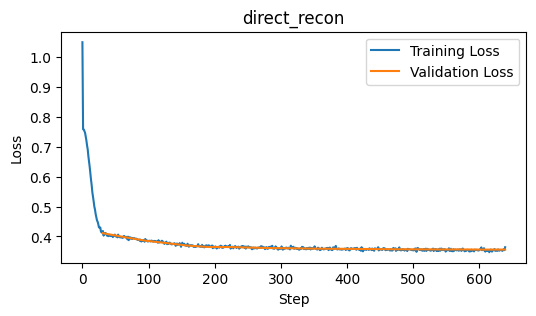

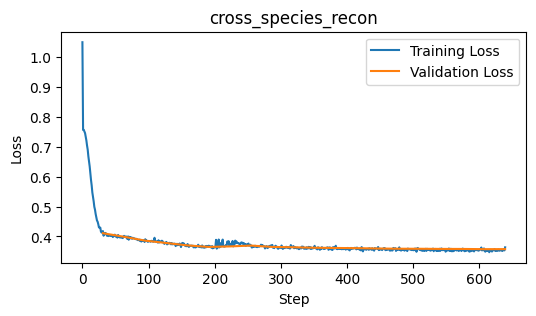

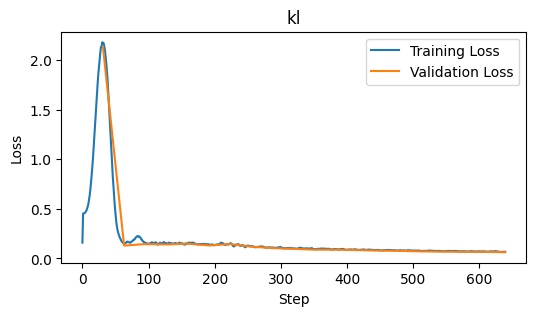

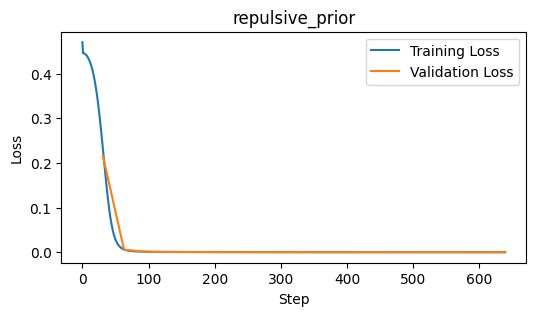

In [8]:
,# Load the latest version
version = max([int(d.split('_')[-1]) for d in glob('logs/metrics/version_*')])
df = pd.read_csv(f'logs/metrics/version_{version}/metrics.csv')


for loss_type in ["direct_recon", "cross_species_recon", "kl", "repulsive_prior"]:
    # Get specific metrics
    train_loss = df[f'train_{loss_type}'][df[f'train_{loss_type}'] != 0.0]
    train_step = df['step'][df[f'train_{loss_type}'] != 0.0]
    f1 = ~train_loss.isna()
    val_loss =  df[f'val_{loss_type}']#[df[f'val_{loss_type}'] != 0.0]
    val_step = df['step']#[df[f'val_{loss_type}'] != 0.0]    
    f2 = ~val_loss.isna()

    # Plot
    import matplotlib.pyplot as plt
    plt.figure(figsize=(6, 3))
    plt.plot(train_step[f1], train_loss[f1], label='Training Loss')
    plt.plot(val_step[f2], val_loss[f2], label='Validation Loss')

    plt.xlabel('Step')
    plt.ylabel('Loss')
    plt.title(loss_type)
    plt.legend()

Species 1 0.36775727749172005 0.6550612919994573
Species 2 0.3026058822868574 0.5931420955150751
Cross species 0.21256510230252687
Cross species 1 0.37016872975004905 0.5728030802717299
Cross species 1 leiden 0.35549185917103854 0.6441738575025195
Cross species 2 0.15659127927258742 0.44977286938605887
Cross species 2 leiden 0.2980270503606653 0.596035643797018


/opt/jupyter-envs/generate-cross-species/atar-jupyter/conda/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


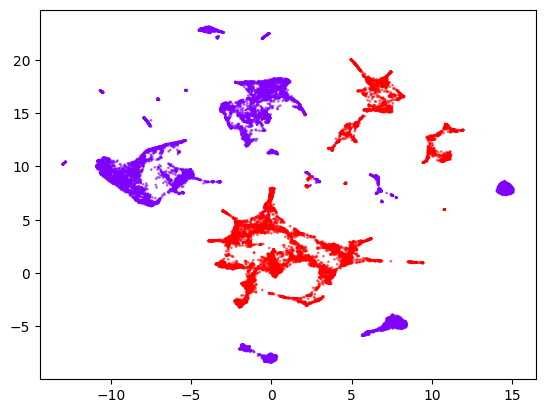

In [10]:
output, s = model.get_latent_embeddings(species_data_sub, batch_size=4096)
latent = output.cpu().numpy()
s=s.cpu().numpy()

#output, s = model.get_latent_embeddings(species_data)
#s=s.cpu().numpy()

#plt.figure();
#dt_full = umap.UMAP(n_components=2).fit_transform(output.detach().cpu().numpy())
#plt.scatter(dt_full[:,0],dt_full[:,1], c = s,s=5, cmap='rainbow'); plt.colorbar()

for i, adata, key in zip([0, 1], [species_data_sub['fish'], species_data_sub['frog']], ['cell_type', 'cell_type']):
    # dt = dt_full[s==i] # umap.UMAP(n_components=2).fit_transform(output[s==i].detach().cpu().numpy())

    adata.obsm['emb'] = latent[s==i]
    sc.pp.neighbors(adata, use_rep='emb')
    sc.tl.leiden(adata, flavor="igraph", n_iterations=2, resolution=2)
    print(f"Species {i+1}", adjusted_rand_score(adata.obs[key], adata.obs['leiden']), adjusted_mutual_info_score(adata.obs[key], adata.obs['leiden']))
    
#     plt.figure();
#     plt.scatter(dt[:,0],dt[:,1], c = adata.obs[key].cat.codes,s=5, cmap='rainbow'); plt.colorbar()
    
adatas = []
for i, k in enumerate(species_data_sub):
    adata = species_data_sub[k]
    adata.obsm['emb'] = latent[s==i]
    adata.obs['species'] = k
    adatas.append(adata)

adata = anndata.concat(adatas,join='outer')

nnm1v2 = _united_proj(latent[s==0],latent[s==1], k=15, metric='cosine')
nnm2v1 = _united_proj(latent[s==1],latent[s==0], k=15, metric='cosine')

sc.pp.neighbors(adata, use_rep='emb')
adata.obsp['connectivities'] = sp.sparse.vstack((sp.sparse.hstack((sp.sparse.csr_matrix((nnm1v2.shape[0],nnm1v2.shape[0])), nnm1v2)),
sp.sparse.hstack((nnm2v1, sp.sparse.csr_matrix((nnm2v1.shape[0],nnm2v1.shape[0]))))))
sc.tl.leiden(adata, flavor="igraph", n_iterations=2, resolution=2)
print("Cross species", adjusted_rand_score(adata.obs['cell_type'], adata.obs['leiden']))

x,y = nnm1v2.nonzero()
cl1 = np.array(list(adata1.obs['cell_type']))
cl2 = np.array(list(adata2.obs['cell_type']))

a = cl2[y.reshape((nnm1v2.shape[0], 15))]
cl1_new = []
for i in range(a.shape[0]):
    b,v = np.unique(a[i],return_counts=True)
    cl1_new.append(b[np.argmax(v)])

cl1_new = np.array(cl1_new)

print("Cross species 1", adjusted_rand_score(adata1.obs['cell_type'], cl1_new), adjusted_mutual_info_score(adata1.obs['cell_type'], cl1_new))
print("Cross species 1 leiden", adjusted_rand_score(adata1.obs['leiden'], cl1_new), adjusted_mutual_info_score(adata1.obs['leiden'], cl1_new))

x,y = nnm2v1.nonzero()

a = cl1[y.reshape((nnm2v1.shape[0], 15))]
cl2_new = []
for i in range(a.shape[0]):
    b,v = np.unique(a[i],return_counts=True)
    cl2_new.append(b[np.argmax(v)])

cl2_new = np.array(cl2_new)

print("Cross species 2", adjusted_rand_score(adata2.obs['cell_type'], cl2_new), adjusted_mutual_info_score(adata2.obs['cell_type'], cl2_new))
print("Cross species 2 leiden", adjusted_rand_score(adata2.obs['leiden'], cl2_new), adjusted_mutual_info_score(adata2.obs['leiden'], cl2_new))

plt.figure();
dt_full = umap.UMAP(n_components=2).fit_transform(output.detach().cpu().numpy())
plt.scatter(dt_full[:,0],dt_full[:,1],c=s,s=1, alpha=0.5, cmap='rainbow');

In [11]:
torch.exp(model.parametric_clusterer.log_sigma)

tensor(0.9522, device='cuda:0', grad_fn=<ExpBackward0>)

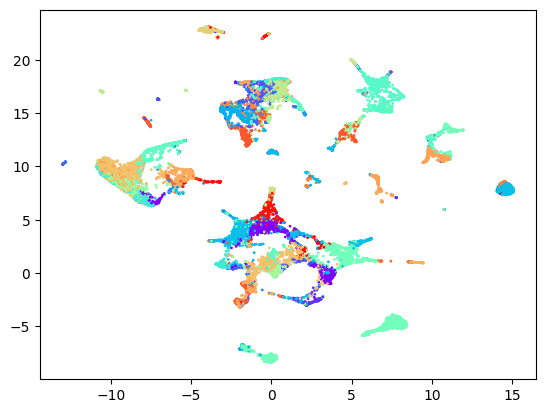

In [12]:
c = model.parametric_clusterer(output.to('cuda'))
c_memberships = c.detach().cpu().numpy()
c = np.argmax(c_memberships,axis=1)
plt.figure(); plt.scatter(dt_full[:,0],dt_full[:,1],c=c,cmap='rainbow',s=1);

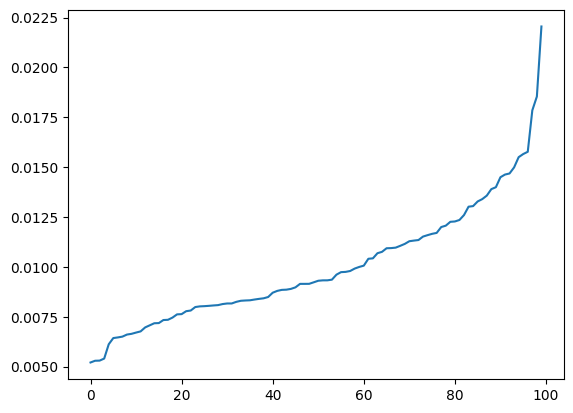

In [16]:
plt.figure(); plt.plot(np.sort(c_memberships.mean(0)))

In [14]:
adjusted_mutual_info_score(species_data_sub['fish'].obs['cell_type'],c[s==0]), adjusted_mutual_info_score(species_data_sub['fish'].obs['cell_type'],species_data_sub['fish'].obs['leiden'])

(0.5429218955556828, 0.6550612919994573)

In [15]:
adjusted_mutual_info_score(species_data_sub['frog'].obs['cell_type'],c[s==1]), adjusted_mutual_info_score(species_data_sub['frog'].obs['cell_type'],species_data_sub['frog'].obs['leiden'])

(0.42912054895561125, 0.5931420955150751)

# STOP HERE

In [24]:
A = np.unique(c[s==0])
B = np.unique(c[s==1])

In [34]:
cl = np.array(list(species_data_sub['fish'].obs['cell_type']) + list(species_data_sub['frog'].obs['cell_type']))
cl = np.array([("FROG_" if i[0]=="S" and "hpf" not in i else "FISH_") + '-'.join(i.split('-')[1:]) for i in cl])

In [52]:
x,y = np.unique(cl[c==11],return_counts=True)
x_all,y_all = np.unique(cl,return_counts=True)
counts = pd.Series(index=x_all,data=y_all)
frac = y / counts[x]

pd.Series(index=x,data=frac).sort_values(ascending=False)

FISH_Optic                         0.381443
FISH_Pharyngeal pouch              0.151515
FISH_Lens                          0.121212
FISH_Heart                         0.104478
FISH_Intermediate mesoderm         0.099593
FISH_Neural crest                  0.085561
FISH_Forebrain/midbrain            0.079059
FISH_Endothelial                   0.078571
FISH_Neural crest - xanthophore    0.050000
FISH_Neural crest - mcamb          0.043478
FISH_Olfactory placode             0.023256
FISH_Otic placode                  0.023256
FISH_Blood                         0.018367
FISH_Macrophage                    0.015625
FISH_Hindbrain                     0.015509
FISH_Endoderm                      0.014286
FISH_Tailbud                       0.008446
FROG_Blood                         0.006250
FISH_Presomitic mesoderm           0.003861
FROG_Intermediate mesoderm         0.003490
dtype: float64

In [25]:
def generate_label_similarity_matrix(latent, s, i, j, name1, name2, K):
    nnm = _united_proj(latent[s==j],latent[s==i], k=K, metric='cosine')
    x, y = nnm.nonzero()
    indices_x = x.reshape((nnm.shape[0],K))
    indices_y = y.reshape((nnm.shape[0],K))
    similarities = nnm.data.reshape((nnm.shape[0],K))


    cl1 = np.array(list(species_data_sub['fish'].obs[name1]))
    cl2 = np.array(list(species_data_sub['frog'].obs[name2]))

    clu1,cluc1 = np.unique(cl1, return_counts=True)
    clu2,cluc2 = np.unique(cl2, return_counts=True)

    C = np.zeros((clu1.size,clu2.size))

    
    df = pd.DataFrame();
    df['labels_0'] = cl1[indices_y].flatten()
    df['labels_1'] = cl2[indices_x].flatten()
    df['similarities'] = similarities.flatten()
    df = df.groupby(['labels_0','labels_1']).sum().reset_index()

    C[pd.Series(index=clu1,data=np.arange(clu1.size))[df['labels_0']].values, pd.Series(index=clu2,data=np.arange(clu2.size))[df['labels_1']].values] = df['similarities'].values
    C = np.stack((C / cluc1[:,None], C/cluc2[None,:]),axis=2).min(2)
    
    return C, clu1, clu2


def format_cross_species_similarities(
    similarity_matrix: np.ndarray,
    source_labels: np.ndarray,
    target_labels: np.ndarray,
    source_species: str = "fish",
    target_species: str = "frog",
    top_n: int | None = None
) -> pd.DataFrame:
    """
    Format similarity matrix into a DataFrame with columns for each species-cell type combination.
    
    Args:
        similarity_matrix: NxM matrix of similarities
        source_labels: N labels from source species
        target_labels: M labels from target species
        source_species: Name of source species
        target_species: Name of target species
        top_n: Optional number of top matches to include (None for all)
    """
    # Create columns for both species
    columns = pd.MultiIndex.from_tuples(
        # Wagner columns
        [(source_species, cell_type, col_name)
         for cell_type in source_labels
         for col_name in ['matched_type', 'similarity']] +
        # Briggs columns
        [(target_species, cell_type, col_name)
         for cell_type in target_labels
         for col_name in ['matched_type', 'similarity']]
    )
    
    # Initialize DataFrame
    max_rows = max(
        len(target_labels) if top_n is None else top_n,
        len(source_labels) if top_n is None else top_n
    )
    df = pd.DataFrame(index=range(max_rows), columns=columns)
    
    # Fill Wagner -> Briggs mappings
    for i, source_label in enumerate(source_labels):
        similarities = similarity_matrix[i]
        sorted_indices = np.argsort(similarities)[::-1]
        if top_n is not None:
            sorted_indices = sorted_indices[:top_n]
            
        df[(source_species, source_label, 'matched_type')] = target_labels[sorted_indices]
        df[(source_species, source_label, 'similarity')] = similarities[sorted_indices]
    
    # Fill Briggs -> Wagner mappings (using transposed similarity matrix)
    similarity_matrix_T = similarity_matrix.T
    for i, target_label in enumerate(target_labels):
        similarities = similarity_matrix_T[i]
        sorted_indices = np.argsort(similarities)[::-1]
        if top_n is not None:
            sorted_indices = sorted_indices[:top_n]
            
        df[(target_species, target_label, 'matched_type')] = source_labels[sorted_indices]
        df[(target_species, target_label, 'similarity')] = similarities[sorted_indices]
    
    return df


In [21]:
latent = adata.obsm['X_pca_harmony']

In [23]:
species_data_sub['fish'].obs['cell_type_strip'] = pd.Categorical(['-'.join(i.split('-')[1:]) for i in species_data_sub['fish'].obs['cell_type']])
species_data_sub['frog'].obs['cell_type_strip'] = pd.Categorical(['-'.join(i.split('-')[1:]) for i in species_data_sub['frog'].obs['cell_type']])

In [26]:
K = 50
# latent = output.cpu().numpy()
C, clu1, clu2 = generate_label_similarity_matrix(latent, s, 0, 1, 'cell_type_strip', 'cell_type_strip', 50)

In [27]:
pd.set_option('display.max_columns', None)

# Create the DataFrame with top 5 matches
similarity_df1 = format_cross_species_similarities(C, clu1, clu2, top_n=5)

In [28]:
similarity_df1['frog']

Blastula                    Blood             \
         matched_type similarity  matched_type similarity   
0            Blastula   3.835860   Endothelial  14.054666   
1  Forebrain/midbrain   0.560049         Blood   9.568823   
2           Hindbrain   0.507448  Neural crest   1.301231   
3               Blood   0.365357         Optic   0.430096   
4        Neural crest   0.347879         Heart   0.429238   

   Cement gland primordium                             Endoderm             \
              matched_type similarity              matched_type similarity   
0                 Ionocyte  11.751819                  Blastula   7.359796   
1  Rare epidermal subtypes   8.676020                  Endoderm   2.417366   
2        Olfactory placode   3.408257              Neural crest   2.354309   
3                 periderm   3.135900  Involuting marginal zone   1.798755   
4            Placodal area   1.833510       Presomitic mesoderm   1.327109   

              Endothelial             Epidermal progenitor             \
             matched_type similarity          matched_type similarity   
0            Neural crest   4.236053  Epidermal progenitor  19.870694   
1      Rohon-beard neuron   3.937459         Placodal area   8.055766   
2    Neural crest - mcamb   2.757258         Neuroectoderm   3.826393   
3                   Heart   2.127825             Hindbrain   3.164905   
4  Neural crest - crestin   1.461976   Non-neural ectoderm   3.098851   

          Eye primordium             Forebrain/midbrain             \
            matched_type similarity        matched_type similarity   
0              Hindbrain   3.525280           Hindbrain   3.013550   
1     Forebrain/midbrain   2.474961  Forebrain/midbrain   2.035172   
2                Tailbud   1.837143             Tailbud   1.140513   
3                  Optic   0.161415        Neural crest   0.230443   
4  Intermediate mesoderm   0.148363     Skeletal muscle   0.182594   

                        Germline                         Goblet cell  \
                    matched_type similarity             matched_type   
0            Secretory epidermal   0.399262                 periderm   
1  neural - floorplate posterior   0.373864  Rare epidermal subtypes   
2                       Ionocyte   0.324679                 Ionocyte   
3        Rare epidermal subtypes   0.270178      Secretory epidermal   
4                       periderm   0.181943           Hatching gland   

                       Hatching gland                              Heart  \
  similarity             matched_type similarity            matched_type   
0  25.083842                 periderm   7.375397    Neural crest - mcamb   
1   8.552651          Pronephric duct   2.280138  Neural crest - crestin   
2   6.098993                 Ionocyte   2.191326            Neural crest   
3   1.079856  Rare epidermal subtypes   1.506943             Endothelial   
4   0.953991      Pancreas primordium   1.491225                   Heart   

                       Hindbrain            Intermediate mesoderm             \
  similarity        matched_type similarity          matched_type similarity   
0   1.864241           Hindbrain  11.290349                 Optic  15.845564   
1   0.802866  Forebrain/midbrain   6.887364    Forebrain/midbrain   5.344411   
2   0.546700             Tailbud   4.073028          Neural crest   4.553411   
3   0.491363              Neuron   3.334715   Presomitic mesoderm   3.235012   
4   0.273185               Optic   0.481007                 Blood   3.138443   

   Involuting marginal zone                            Ionocyte             \
               matched_type similarity             matched_type similarity   
0  Involuting marginal zone  12.425031  Rare epidermal subtypes  12.721988   
1       Presomitic mesoderm   9.250054                 Ionocyte  10.435840   
2              Neural crest   3.340690                 periderm   3.492150   
3                  Endoderm   2.431524      Se

In [56]:
similarity_df1['frog']

S08-Blastula               S10-Endoderm             \
                  matched_type similarity    matched_type similarity   
0               04hpf-Blastula   6.998164  24hpf-Germline   1.239050   
1               14hpf-Germline   0.114150  14hpf-Germline   0.872256   
2  18hpf-Intermediate mesoderm   0.072262  04hpf-Blastula   0.555348   
3               24hpf-Germline   0.062167  18hpf-Germline   0.496966   
4            18hpf-Endothelial   0.051570     14hpf-Heart   0.000000   

  S10-Involuting marginal zone                     S10-Neuroectoderm  \
                  matched_type similarity               matched_type   
0               04hpf-Blastula   7.692196             04hpf-Blastula   
1    18hpf-Presomitic mesoderm   2.650114             14hpf-Germline   
2               24hpf-Germline   1.117043             18hpf-Germline   
3               14hpf-Germline   0.935233             24hpf-Germline   
4               18hpf-Germline   0.726739  18hpf-Presomitic mesoderm   

                  S10-Non-neural ectoderm             \
  similarity                 matched_type similarity   
0  11.163950               04hpf-Blastula   9.748288   
1   0.961928               14hpf-Germline   0.963063   
2   0.948696               18hpf-Germline   0.962757   
3   0.685430               24hpf-Germline   0.566288   
4   0.389523  18hpf-Intermediate mesoderm   0.139203   

       S10-Spemann organizer                               S11-Endoderm  \
                matched_type similarity                    matched_type   
0             04hpf-Blastula   2.270512                  04hpf-Blastula   
1  18hpf-Presomitic mesoderm   1.471951  06hpf-Involuting marginal zone   
2             24hpf-Germline   1.258499                  06hpf-Germline   
3             14hpf-Germline   0.944086                  06hpf-Endoderm   
4             18hpf-Germline   0.751901             06hpf-Neuroectoderm   

                    S11-Epidermal progenitor             \
  similarity                    matched_type similarity   
0   6.168868  06hpf-Involuting marginal zone   7.481147   
1   2.611681             06hpf-Neuroectoderm   4.554577   
2   1.538665       06hpf-Non-neural ectoderm   4.316118   
3   1.073885                  06hpf-Endoderm   3.630870   
4   0.764170                 06hpf-Notochord   3.018001   

                     S11-Germline                            S11-Goblet cell  \
                     matched_type similarity                    matched_type   
0                 06hpf-Notochord   0.213683                  06hpf-Endoderm   
1  06hpf-Involuting marginal zone   0.202143          06hpf-Dorsal organizer   
2                  06hpf-Endoderm   0.184719  06hpf-Involuting marginal zone   
3            06hpf-Apoptotic-like   0.153362                          06hpf-   
4          06hpf-Dorsal organizer   0.117375                 06hpf-Notochord   

                S11-Involuting marginal zone             \
  similarity                    matched_type similarity   
0  15.552058  06hpf-Involuting marginal zone  13.098358   
1  10.876616           24hpf-Skeletal muscle   3.315796   
2   3.400677                  06hpf-Endoderm   2.733505   
3   2.438594                  04hpf-Blastula   1.482929   
4   1.862209            06hpf-Apoptotic-like   1.097341   

             S11-Ionocyte                          S11-Neuroectoderm  \
             matched_type similarity                    matched_type   
0  06hpf-Dorsal organizer   7.034402  06hpf-Involuting marginal zone   
1          06hpf-Endoderm   5.828149             06hpf-Neuroectoderm   
2         06hpf-Notochord   1.992419                  06hpf-Endoderm   
3    06hpf-Apoptotic-like   1.839513       06hpf-Non-neural ectoderm   
4  08hpf-Dorsal organizer   0.995875                 06hpf-Notochord   

                     S11-Non-neural ectoderm             \
  similarity                    matched_type similarity   
0  29.365433  06hpf-Involuting marginal zone  26.832436   
1   4.555881      

0.3453044425431827


In [ ]:
similarity_df['wagner']

In [34]:
from src.single_vae import VAE

# homology_edges, homology_scores = pickle.load(open('homology_zfxe.p','rb'))
# # Loading
# checkpoint = torch.load('model_checkpoint.pt')
# model = CrossSpeciesVAE(
#     homology_edges=homology_edges,
#     homology_scores=homology_scores,
#     **checkpoint['hyper_parameters']
# )
# model.load_state_dict(checkpoint['state_dict'])
# model.eval();  # if using for inference

early_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta=0.0,
    patience=3,
    verbose=True,
    mode='min'
)

# Initialize the trainer
trainer = pl.Trainer(
    accelerator="gpu",
    devices=1,
    max_epochs=10,
    precision='16-mixed',
    gradient_clip_val=model.gradient_clip_val,
    gradient_clip_algorithm="norm",
    log_every_n_steps=1,
    deterministic=True,
    callbacks=[early_stopping],
    accumulate_grad_batches=1,
    enable_progress_bar=True,
    fast_dev_run=False,
    logger=CSVLogger(
        save_dir="logs",
        name="metrics",
        flush_logs_every_n_steps=10
    )    
)

scvi = VAE(
    cross_species_vae = model,
    n_latent = 256,
    hidden_dims = [256],

    batch_size = batch_size,
    base_batch_size = 256,
    
    base_learning_rate = 1e-3,    
    min_learning_rate = 1e-5,
    warmup_data = 0.1,
    
    init_beta = 1e-3,
    final_beta = 1.0,
    
    gradient_clip_val = 1.0,
    gradient_clip_algorithm = "norm",  
    
    deeply_inject_species=False,
)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


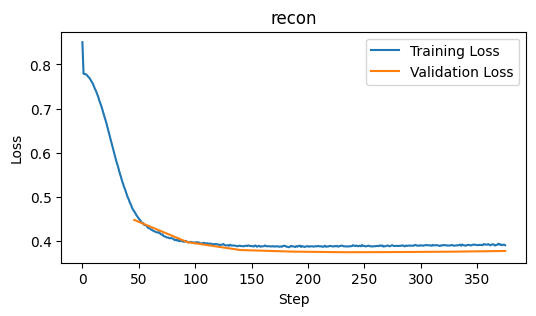

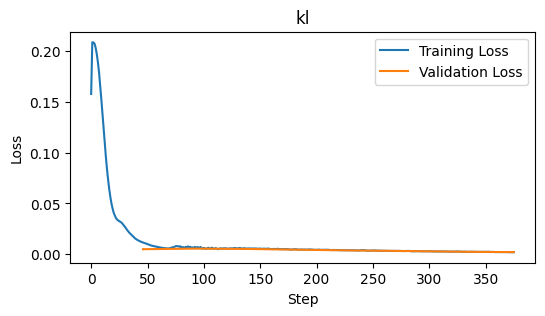

In [36]:
,# Load the latest version
version = max([int(d.split('_')[-1]) for d in glob('logs/metrics/version_*')])
df = pd.read_csv(f'logs/metrics/version_{version}/metrics.csv')


for loss_type in ["recon", "kl"]:
    # Get specific metrics
    train_loss = df[f'train_{loss_type}'][df[f'train_{loss_type}'] != 0.0]
    train_step = df['step'][df[f'train_{loss_type}'] != 0.0]
    f1 = ~train_loss.isna()
    val_loss =  df[f'val_{loss_type}']#[df[f'val_{loss_type}'] != 0.0]
    val_step = df['step']#[df[f'val_{loss_type}'] != 0.0]    
    f2 = ~val_loss.isna()

    # Plot
    import matplotlib.pyplot as plt
    plt.figure(figsize=(6, 3))
    plt.plot(train_step[f1], train_loss[f1], label='Training Loss')
    plt.plot(val_step[f2], val_loss[f2], label='Validation Loss')

    plt.xlabel('Step')
    plt.ylabel('Loss')
    plt.title(loss_type)
    plt.legend()

In [37]:
output,s = scvi.get_latent_embeddings(species_data_sub, batch_size=4096)
s=s.cpu().numpy()


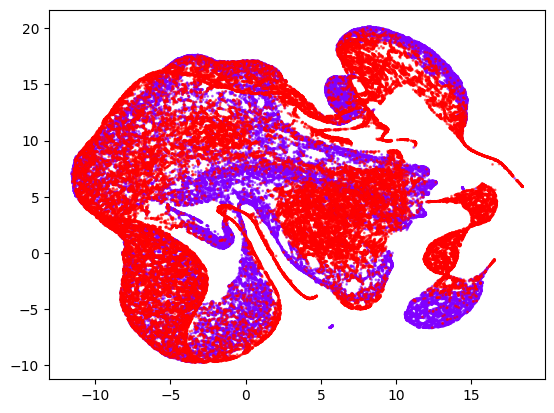

In [38]:
plt.figure();
dt_full = umap.UMAP(n_components=2).fit_transform(output.detach().cpu().numpy())
plt.scatter(dt_full[:,0],dt_full[:,1],c=s,s=1, alpha=0.5, cmap='rainbow');

0.397577899283943
0.361115285788397


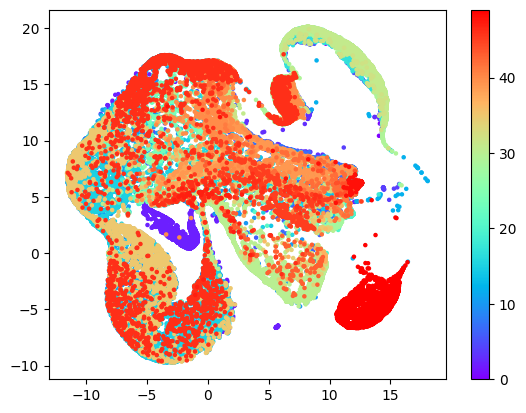

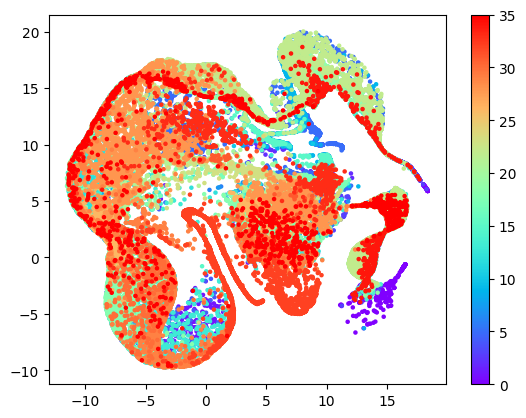

In [39]:
for i, adata, key in zip([0, 1], [species_data_sub['wagner'], species_data_sub['briggs']], ['cell_type', 'cell_type']):
    dt = dt_full[s==i]

    adata.obsm['emb'] = dt
    sc.pp.neighbors(adata, use_rep='emb')
    sc.tl.leiden(adata, flavor="igraph", n_iterations=2, resolution=2)
    print(adjusted_mutual_info_score(adata.obs[key], adata.obs['leiden']))
    
    plt.figure();
    plt.scatter(dt[:,0],dt[:,1], c = adata.obs[key].cat.codes,s=5, cmap='rainbow'); plt.colorbar()
    

In [19]:
latent = output.cpu().numpy()
adatas = []
for i, k in enumerate(species_data_sub):
    adata = species_data_sub[k]
    adata.obsm['emb'] = latent[s==i]
    adata.obs['species'] = k
    adatas.append(adata)

adata = anndata.concat(adatas,join='outer')
adata.obsm['X_umap'] = dt_full

import scanpy as sc

sc.external.pp.harmony_integrate(adata, "species", basis='emb', adjusted_basis='X_pca_harmony')

adata.obsm['X_umap'] = umap.UMAP().fit_transform(adata.obsm['X_pca_harmony'])

2024-12-28 18:26:26,433 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2024-12-28 18:26:29,053 - harmonypy - INFO - sklearn.KMeans initialization complete.
2024-12-28 18:26:29,096 - harmonypy - INFO - Iteration 1 of 10
2024-12-28 18:26:33,370 - harmonypy - INFO - Iteration 2 of 10
2024-12-28 18:26:37,664 - harmonypy - INFO - Iteration 3 of 10
2024-12-28 18:26:41,969 - harmonypy - INFO - Iteration 4 of 10
2024-12-28 18:26:46,027 - harmonypy - INFO - Iteration 5 of 10
2024-12-28 18:26:49,948 - harmonypy - INFO - Iteration 6 of 10
2024-12-28 18:26:54,243 - harmonypy - INFO - Iteration 7 of 10
2024-12-28 18:26:58,604 - harmonypy - INFO - Iteration 8 of 10
2024-12-28 18:27:02,946 - harmonypy - INFO - Converged after 8 iterations
/opt/jupyter-envs/generate-cross-species/atar-jupyter/conda/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.war

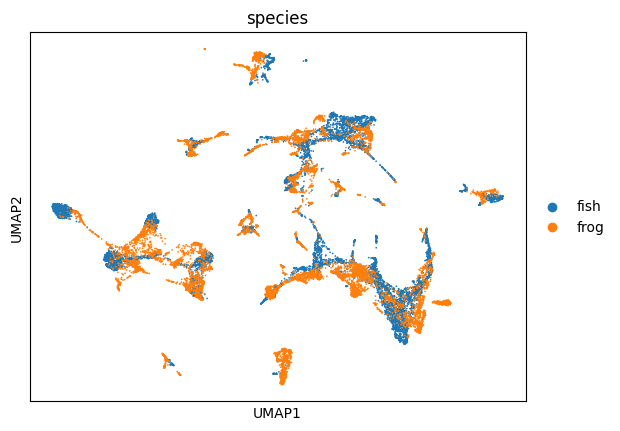

In [20]:
sc.pl.umap(adata,color='species')

In [17]:
K = 50
latent = adata.obsm['X_pca_harmony']

nnm = _united_proj(latent[s==1],latent[s==0], k=K, metric='cosine')
x, y = nnm.nonzero()
indices_x = x.reshape((nnm.shape[0],K))
indices_y = y.reshape((nnm.shape[0],K))
similarities = nnm.data.reshape((nnm.shape[0],K))


cl1 = np.array(list(species_data_sub['wagner'].obs['cell_type']))
cl2 = np.array(list(species_data_sub['briggs'].obs['cell_type']))

clu1,cluc1 = np.unique(cl1, return_counts=True)
clu2,cluc2 = np.unique(cl2, return_counts=True)

C = np.zeros((clu1.size,clu2.size))


df = pd.DataFrame();
df['labels_0'] = cl1[indices_y].flatten()
df['labels_1'] = cl2[indices_x].flatten()
df['similarities'] = similarities.flatten()
df = df.groupby(['labels_0','labels_1']).sum().reset_index()

C[pd.Series(index=clu1,data=np.arange(clu1.size))[df['labels_0']].values, pd.Series(index=clu2,data=np.arange(clu2.size))[df['labels_1']].values] = df['similarities'].values
C = np.stack((C / cluc1[:,None], C/cluc2[None,:]),axis=2).min(2)


In [18]:
similarity_df = format_cross_species_similarities(C, clu1, clu2, top_n=10)

In [19]:
similarity_df['briggs']

Blastula                          Blood             \
              matched_type similarity        matched_type similarity   
0                 Endoderm   3.575150               Optic   4.526556   
1      Presomitic mesoderm   2.301391  Forebrain/midbrain   1.665320   
2  Rare epidermal subtypes   1.880021           Hindbrain   1.575716   
3      Non-neural ectoderm   1.580697        Neural crest   0.370278   
4    Intermediate mesoderm   1.468018             Tailbud   0.237750   
5                  Tailbud   1.143198               Heart   0.212100   
6         Dorsal organizer   1.130175                Lens   0.056131   
7                 Germline   0.976103            Endoderm   0.043676   
8             Neural crest   0.825734  Rohon-beard neuron   0.031152   
9                    Heart   0.796415   Olfactory placode   0.018620   

   Cement gland primordium                             Endoderm             \
              matched_type similarity              matched_type similarity   
0     Epidermal progenitor   5.566423  Involuting marginal zone   3.549161   
1            Placodal area   1.974336                  Endoderm   3.104826   
2              Endothelial   1.722419          Dorsal organizer   2.773489   
3  Rare epidermal subtypes   0.798470     Intermediate mesoderm   2.182292   
4   Neural crest - crestin   0.545541              Neural crest   2.135392   
5                    Heart   0.498838       Presomitic mesoderm   1.860331   
6    Intermediate mesoderm   0.475478       Non-neural ectoderm   1.779196   
7                      NaN   0.436580                   Tailbud   1.564154   
8         Pharyngeal pouch   0.405387             Neuroectoderm   1.536026   
9             Otic placode   0.358465                     Heart   1.417260   

            Endothelial                 Epidermal progenitor             \
           matched_type similarity              matched_type similarity   
0                 Optic   2.203406      Epidermal progenitor  12.061454   
1          Neural crest   1.271730     Intermediate mesoderm   8.635573   
2    Forebrain/midbrain   1.129656               pluripotent   8.318399   
3             Hindbrain   0.771604             Neuroectoderm   1.679391   
4                 Heart   0.640465  Involuting marginal zone   1.652851   
5               Tailbud   0.268082             Placodal area   1.650957   
6                  Lens   0.102879                  periderm   1.486540   
7    Rohon-beard neuron   0.102857                  Endoderm   1.342475   
8  Neural crest - mcamb   0.082310   Rare epidermal subtypes   1.315267   
9              Endoderm   0.064136                    Neuron   1.280491   

          Eye primordium                Forebrain/midbrain             \
            matched_type similarity           matched_type similarity   
0              Hindbrain   3.640943              Hindbrain   3.031546   
1     Forebrain/midbrain   2.432176     Forebrain/midbrain   2.052431   
2                 Neuron   0.778933                Tailbud   1.261222   
3                Tailbud   0.772233                 Neuron   0.229787   
4                  Optic   0.398815           Neural crest   0.160965   
5           Neural crest   0.170133                  Optic   0.150223   
6   Epidermal progenitor   0.131762                  Heart   0.088701   
7                  Heart   0.124126    Presomitic mesoderm   0.061660   
8  Intermediate mesoderm   0.109674  Intermediate mesoderm   0.052845   
9    Presomitic mesoderm   0.080908   Neural crest - mcamb   0.049897   

             Germline                         Goblet cell             \
         matched_type similarity             matched_type similarity   
0    Dorsal organizer   0.539338     Epidermal progenitor  13.493476   
1              Neuron   0.146332            Placodal area   4.053374   
2            Germline   0.124720              Endothelial   3.534064   
3      Apoptotic-like   0.076797                Notochord   2.375823   
4     

In [30]:
similarity_df['wagner']

Apoptotic-like                    Apoptotic-like 2             \
               matched_type similarity             matched_type similarity   
0               Goblet cell   1.534429           Hatching gland   1.933726   
1           Skeletal muscle   1.452351  Cement gland primordium   1.231252   
2                  Ionocyte   0.997829              Goblet cell   1.182472   
3            Hatching gland   0.844330                 Ionocyte   0.647573   
4   Cement gland primordium   0.514566     Epidermal progenitor   0.039873   
5      Epidermal progenitor   0.156182    Intermediate mesoderm   0.002613   
6       Presomitic mesoderm   0.100865      Non-neural ectoderm   0.002073   
7                  Germline   0.038331                  Tailbud   0.000000   
8       Non-neural ectoderm   0.022801          Skeletal muscle   0.000000   
9  Involuting marginal zone   0.011419    Small secretory cells   0.000000   

                      Blood                    Dorsal organizer             \
               matched_type similarity             matched_type similarity   
0             Neuroectoderm  13.593547                Notochord   4.419354   
1       Non-neural ectoderm  11.730256  Cement gland primordium   3.878493   
2      Epidermal progenitor   5.491779                 Ionocyte   2.852849   
3  Involuting marginal zone   4.695822          Skeletal muscle   1.429085   
4                   Tailbud   1.380822              Goblet cell   1.164614   
5         Spemann organizer   1.133783           Hatching gland   0.431188   
6                  Endoderm   1.108443                 Endoderm   0.130419   
7               Goblet cell   0.546601      Presomitic mesoderm   0.100894   
8                  Ionocyte   0.507799     Epidermal progenitor   0.057084   
9     Intermediate mesoderm   0.255642                  Tailbud   0.039055   

                     EVL                             Endoderm             \
            matched_type similarity              matched_type similarity   
0                Tailbud        0.0                  Blastula   3.848298   
1      Spemann organizer        0.0               Goblet cell   3.096677   
2  Small secretory cells        0.0                  Endoderm   2.802400   
3        Skeletal muscle        0.0                  Ionocyte   2.265534   
4     Rohon-beard neuron        0.0                 Notochord   1.754054   
5  Pronephric mesenchyme        0.0           Skeletal muscle   1.619428   
6    Presomitic mesoderm        0.0         Spemann organizer   1.545394   
7          Placodal area        0.0   Cement gland primordium   1.467240   
8           Otic placode        0.0  Involuting marginal zone   1.399352   
9                  Optic        0.0                    Neuron   0.659870   

                Endothelial                 Epidermal progenitor             \
               matched_type similarity              matched_type similarity   
0                  Blastula   1.062047  Involuting marginal zone   1.308060   
1  Involuting marginal zone   0.224115                 Notochord   1.140634   
2         Spemann organizer   0.093163         Spemann organizer   0.817123   
3                    Neuron   0.090690             Neuroectoderm   0.542746   
4             Neuroectoderm   0.074393       Non-neural ectoderm   0.349796   
5                 Notochord   0.064249                   Tailbud   0.207321   
6       Non-neural ectoderm   0.040292                  Endoderm   0.147765   
7        Forebrain/midbrain   0.022164       Presomitic mesoderm   0.128221   
8                  Endoderm   0.018637                    Neuron   0.127874   
9                  Germline   0.014362                  Blastula   0.121720   

             Eye primordium                   Forebrain/midbrain             \
               matched_type similarity              matched_type similarity   
0               Goblet cell   0.824736       Non-neural ectoderm   4.135457   
1                  Endoderm   0.158537  